## 1. Data


In [ ]:
pip install pandas yfinance
pip install Ta-Lib

In [24]:
# neccessary library
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

In [25]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.1 S&P 500 history data

In this analysis, I conducted a thorough examination and feature engineering of the S&P 500 historical data using advanced Python programming techniques. The dataset was sourced from Yahoo Finance, covering the period from January 1, 2001, to January 1, 2023. The primary objective was to prepare a comprehensive dataset that would enhance the efficacy of a subsequent LSTM (Long Short-Term Memory) model training. The technical indicators calculated are crucial for financial time series analysis and include:

1. **Simple Moving Averages (SMA)**: The 50-day and 200-day SMAs were computed to provide insights into long-term and medium-term trends.
2. **Relative Strength Index (RSI)**: This momentum oscillator was calculated to identify overbought or oversold conditions.
3. **Stochastic Oscillator**: Incorporating both %K and %D lines, this indicator was used to predict price turning points by comparing the closing price to its price range.
4. **Bollinger Bands**: These bands were added to identify the volatility and relative price levels over a period.
5. **Moving Average Convergence Divergence (MACD)**: This trend-following momentum indicator shows the relationship between two moving averages of the price.
6. **Average True Range (ATR)**: Implemented to measure market volatility.
7. **Williams %R**: This momentum indicator was included to detect overbought and oversold levels.

In addition to these standard financial indicators, I integrated several time-related features, such as date and day of the year. Seasonal patterns were encoded using cosine functions, capturing both yearly and weekly seasonality, which are pivotal for LSTM models dealing with time series data. A first-order differencing of the closing price was also performed to incorporate immediate past price movements into the analysis, enhancing the model's predictive accuracy.

The data transformation and feature engineering steps undertaken were crucial for preparing a robust dataset, aimed at optimizing the LSTM model's performance in forecasting future trends of the S&P 500 index. The refined structure and comprehensive nature of the dataset serve as a solid foundation for advanced predictive modeling in financial time series analysis.


In my approach to enhancing LSTM (Long Short-Term Memory) model training for financial time series forecasting, I have chosen to integrate technical analysis indicators into the dataset, marking a significant advancement beyond traditional methodologies. My rationale for this integration is based on several key benefits these indicators offer:

1. **Enhanced Market Insight**: By incorporating indicators like SMA, RSI, MACD, and others, I gain a more nuanced understanding of market trends, momentum, volatility, and investor sentiment. This depth of insight is crucial for an LSTM model, which excels at recognizing patterns over time.

2. **Improved Model Robustness**: The LSTM's capability to remember long-term dependencies is complemented by these indicators, as they encapsulate historical market behaviors and trends. This integration leads to a more robust and accurate forecasting model.

3. **Competitive Edge**: Standard LSTM models primarily rely on price and volume data. By including technical indicators, I provide the model with a competitive edge. These indicators offer a multi-dimensional view of the market, allowing the model to learn from a broader range of market signals.

4. **Reduction of Noise**: Technical indicators help in filtering out the 'noise' in raw price data, making underlying trends and patterns more discernible for the LSTM model. This is especially beneficial in volatile markets, where noise can significantly impact data interpretation.

5. **Predictive Power**: Many of these indicators, such as moving averages and oscillators like RSI and Williams %R, have proven predictive capabilities. Incorporating these into the LSTM model enhances its predictive accuracy.

6. **Adaptability to Market Conditions**: These indicators adapt well to different market conditions, whether trending or range-bound. This versatility ensures that the LSTM model remains effective across various market scenarios.

By incorporating these technical analysis indicators, my LSTM model processes not just raw numbers, but a dataset that encapsulates a comprehensive understanding of market behaviors and trends. This approach aligns with the latest advancements in financial modeling, focusing on capturing as much relevant market information as possible to enhance the predictive accuracy and reliability of the model.

In [26]:
import pandas as pd
import yfinance as yf

# Set the start and end dates
start_date = "2001-01-01"
end_date = "2023-01-01"

# Download historical data for S&P 500
sp500_data = yf.download('^GSPC', start=start_date, end=end_date)

# Calculate Moving Averages
sp500_data['SMA_50'] = sp500_data['Close'].rolling(window=50).mean()
sp500_data['SMA_200'] = sp500_data['Close'].rolling(window=200).mean()

# Calculate RSI (Relative Strength Index)
def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

sp500_data['RSI'] = calculate_rsi(sp500_data)

# Calculate Stochastic Oscillator
def calculate_stochastic(data, window=14):
    lowest_low = data['Low'].rolling(window=window).min()
    highest_high = data['High'].rolling(window=window).max()
    data['%K'] = ((data['Close'] - lowest_low) / (highest_high - lowest_low)) * 100
    data['%D'] = data['%K'].rolling(window=3).mean()
    return data

sp500_data = calculate_stochastic(sp500_data)

# Calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20):
    data['MiddleBB'] = data['Close'].rolling(window=window).mean()
    data['UpperBB'] = data['MiddleBB'] + 2 * data['Close'].rolling(window=window).std()
    data['LowerBB'] = data['MiddleBB'] - 2 * data['Close'].rolling(window=window).std()
    return data

sp500_data = calculate_bollinger_bands(sp500_data)

# Calculate MACD (Moving Average Convergence Divergence)
def calculate_macd(data, short_window=12, long_window=26):
    data['ShortEMA'] = data['Close'].ewm(span=short_window).mean()
    data['LongEMA'] = data['Close'].ewm(span=long_window).mean()
    data['MACD'] = data['ShortEMA'] - data['LongEMA']
    data['SignalLine'] = data['MACD'].ewm(span=9).mean()
    return data

sp500_data = calculate_macd(sp500_data)

# Calculate ATR (Average True Range)
def calculate_atr(data, window=14):
    tr = data['High'].combine(data['Close'].shift(), max) - data['Low'].combine(data['Close'].shift(), min)
    atr = tr.rolling(window=window).mean()
    return atr

sp500_data['ATR'] = calculate_atr(sp500_data)

# Calculate Williams %R
def calculate_williams_r(data, window=14):
    highest_high = data['High'].rolling(window=window).max()
    lowest_low = data['Low'].rolling(window=window).min()
    data['Williams %R'] = ((highest_high - data['Close']) / (highest_high - lowest_low)) * -100
    return data

sp500_data = calculate_williams_r(sp500_data)


# Add time features
sp500_data['Date_f'] = sp500_data.index
sp500_data['Day_of_Year'] = sp500_data['Date_f'].dt.dayofyear

# Encode seasonality and periodicity factors using cosine functions
def encode_seasonality(data, period, feature_name):
    data[feature_name] = np.cos(2 * np.pi * data['Day_of_Year'] / period)
    return data

# Encode yearly seasonality
sp500_data = encode_seasonality(sp500_data, 365, 'Yearly_Seasonality')

# Encode weekly seasonality
sp500_data = encode_seasonality(sp500_data, 7, 'Weekly_Seasonality')


# Perform differencing (first-order difference)
sp500_data['Close_Diff'] = sp500_data['Close'].diff()


sp500_data.columns = sp500_data.columns.str.lower()
sp500_data.columns = ['SPX_' + col if col != 'date' else col for col in sp500_data.columns]


# Display the head of the data, including the newly calculated technical indicators
print(sp500_data.head())


[*********************100%%**********************]  1 of 1 completed
               SPX_open     SPX_high      SPX_low    SPX_close  SPX_adj close  \
Date                                                                            
2001-01-02  1320.280029  1320.280029  1276.050049  1283.270020    1283.270020   
2001-01-03  1283.270020  1347.760010  1274.619995  1347.560059    1347.560059   
2001-01-04  1347.560059  1350.239990  1329.140015  1333.339966    1333.339966   
2001-01-05  1333.339966  1334.770020  1294.949951  1298.349976    1298.349976   
2001-01-08  1298.349976  1298.349976  1276.290039  1295.859985    1295.859985   

            SPX_volume  SPX_sma_50  SPX_sma_200  SPX_rsi  SPX_%k  ...  \
Date                                                              ...   
2001-01-02  1129400000         NaN          NaN      NaN     NaN  ...   
2001-01-03  1880700000         NaN          NaN      NaN     NaN  ...   
2001-01-04  2131000000         NaN          NaN      NaN     NaN  ...  

In [27]:
sp500_data.columns

Index(['SPX_open', 'SPX_high', 'SPX_low', 'SPX_close', 'SPX_adj close',
       'SPX_volume', 'SPX_sma_50', 'SPX_sma_200', 'SPX_rsi', 'SPX_%k',
       'SPX_%d', 'SPX_middlebb', 'SPX_upperbb', 'SPX_lowerbb', 'SPX_shortema',
       'SPX_longema', 'SPX_macd', 'SPX_signalline', 'SPX_atr',
       'SPX_williams %r', 'SPX_date_f', 'SPX_day_of_year',
       'SPX_yearly_seasonality', 'SPX_weekly_seasonality', 'SPX_close_diff'],
      dtype='object')

## 1.2 VIX data

In [28]:
import pandas as pd
import yfinance as yf

# Download VIX data
vix_data = yf.download('^VIX', start="2001-01-01", end="2023-01-01")

# Convert column names to lowercase
vix_data.columns = vix_data.columns.str.lower()

# Create a 'date' column based on the index
vix_data['date'] = vix_data.index

# Reset the index and move the 'date' column to the first position
vix_data.reset_index(drop=True, inplace=True)
vix_data = vix_data[['date'] + [col for col in vix_data.columns if col != 'date']]

# Add "vix_" prefix to all column names (except 'date')
vix_data.columns = ['vix_' + col if col != 'date' else col for col in vix_data.columns]

# Print the processed data
print(vix_data.head())


[*********************100%%**********************]  1 of 1 completed
        date   vix_open   vix_high    vix_low  vix_close  vix_adj close  \
0 2001-01-02  27.930000  30.400000  27.920000  29.990000      29.990000   
1 2001-01-03  29.629999  29.959999  25.990000  26.600000      26.600000   
2 2001-01-04  26.350000  27.190001  26.129999  26.969999      26.969999   
3 2001-01-05  27.809999  29.040001  27.209999  28.670000      28.670000   
4 2001-01-08  29.980000  30.799999  29.719999  29.840000      29.840000   

   vix_volume  
0           0  
1           0  
2           0  
3           0  
4           0  


## 1.3 Macro data： CPI and unrate

In [29]:
import pandas as pd

# Define the file path for CPI data
file_path = "/content/drive/My Drive/EE590/Data/CPIAUCSL.csv"

# Read the CSV file
cpi_data = pd.read_csv(file_path)

# Convert column names to lowercase
cpi_data.columns = cpi_data.columns.str.lower()

# Display the last few rows of the DataFrame
cpi_data.tail()

# Parse the 'date' field as datetime
cpi_data['date'] = pd.to_datetime(cpi_data['date'])

# Select a time range
start_date = "2001-01-01"
end_date = "2023-01-01"
cpi_data = cpi_data[(cpi_data['date'] >= start_date) & (cpi_data['date'] <= end_date)]

# Shift the date by one month since the data is reported with a one-month lag
cpi_data['date'] = cpi_data['date'] - pd.DateOffset(months=1)

# Parse the 'date' field as datetime again
cpi_data['date'] = pd.to_datetime(cpi_data['date'])

# Calculate percentage changes for different months (1, 3, 6, 12 months)
cpi_data['CPI_1_Month_Percent_Change'] = cpi_data['cpiaucsl'].pct_change(periods=1) * 100
cpi_data['CPI_3_Month_Percent_Change'] = cpi_data['cpiaucsl'].pct_change(periods=3) * 100
cpi_data['CPI_6_Month_Percent_Change'] = cpi_data['cpiaucsl'].pct_change(periods=6) * 100
cpi_data['CPI_12_Month_Percent_Change'] = cpi_data['cpiaucsl'].pct_change(periods=12) * 100

# Calculate trends (3 and 12 months)
cpi_data['CPI_3_Month_Trend'] = cpi_data['cpiaucsl'].diff(periods=3)
cpi_data['CPI_12_Month_Trend'] = cpi_data['cpiaucsl'].diff(periods=12)


# # 使用线性插值填充缺失值
cpi_data = cpi_data.set_index('date').resample('D').interpolate()

# Print the last few rows of the cleaned DataFrame
cpi_data.tail()


,cpiaucsl,CPI_1_Month_Percent_Change,CPI_3_Month_Percent_Change,CPI_6_Month_Percent_Change,CPI_12_Month_Percent_Change,CPI_3_Month_Trend,CPI_12_Month_Trend
date,,,,,,,
2022-11-27,300.329867,0.465635,0.851557,1.930686,6.360194,2.535933,17.959133
2022-11-28,300.381400,0.478495,0.852519,1.949324,6.356935,2.539200,17.953600
2022-11-29,300.432933,0.491355,0.853482,1.967963,6.353675,2.542467,17.948067
2022-11-30,300.484467,0.504214,0.854444,1.986602,6.350416,2.545733,17.942533
2022-12-01,300.536000,0.517074,0.855406,2.005241,6.347156,2.549000,17.937000


## 1.4 Treasury rate

In [30]:
import pandas as pd

# Define the file path
file_path = "/content/drive/My Drive/EE590/Data/FRB_H15-4.csv"

# Read the CSV file, skipping the first 5 rows (header)
treasury_data = pd.read_csv(file_path, header=5)

# Convert column names to lowercase
treasury_data.columns = treasury_data.columns.str.lower()

# Display the last few rows of the DataFrame
treasury_data.tail()

# Rename columns for clarity
treasury_data.columns = ['date', '1-month TYield', '3-month TYield', '6-month TYield', '1-year TYield', '2-year TYield', '3-year TYield', '5-year TYield', '7-year TYield', '10-year TYield', '20-year TYield', '30-year TYield']

# Display the updated column names
print(treasury_data.columns)

# Parse the 'date' field as datetime
treasury_data['date'] = pd.to_datetime(treasury_data['date'])

# Select a time range
start_date = "2001-01-01"
end_date = "2023-01-01"
treasury_data = treasury_data[(treasury_data['date'] >= start_date) & (treasury_data['date'] <= end_date)]

# Fill "ND" values with the previous data
treasury_data = treasury_data.replace('ND', pd.NA).fillna(method='ffill')
treasury_data = treasury_data.fillna(method="ffill")

# Display the first 5 rows of the cleaned DataFrame
treasury_data.head(5)


Index(['date', '1-month TYield', '3-month TYield', '6-month TYield',
       '1-year TYield', '2-year TYield', '3-year TYield', '5-year TYield',
       '7-year TYield', '10-year TYield', '20-year TYield', '30-year TYield'],
      dtype='object')


,date,1-month TYield,3-month TYield,6-month TYield,1-year TYield,2-year TYield,3-year TYield,5-year TYield,7-year TYield,10-year TYield,20-year TYield,30-year TYield
10174,2001-01-01,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
10175,2001-01-02,NaN,5.87,5.58,5.11,4.87,4.82,4.76,4.97,4.92,5.46,5.35
10176,2001-01-03,NaN,5.69,5.44,5.04,4.92,4.92,4.94,5.18,5.14,5.62,5.49
10177,2001-01-04,NaN,5.37,5.20,4.82,4.77,4.78,4.82,5.07,5.03,5.56,5.44
10178,2001-01-05,NaN,5.12,4.98,4.60,4.56,4.57,4.66,4.93,4.93,5.50,5.41


## 2. 4 Merged data

In [31]:
print(len(sp500_data))
print(len(vix_data))
print(len(cpi_data))
print(len(treasury_data))

5535
5535
8036
5740


In [32]:
# Merge DataFrames: sp500_data, vix_data, cpi_data, and treasury_data

# Concatenate the four DataFrames along the column direction, aligning them based on the 'date' column
dfs = [sp500_data, vix_data.set_index('date'), cpi_data, treasury_data.set_index('date')]
merged_data = pd.concat(dfs, axis=1, join='inner')

# Print the columns of the merged data
print(merged_data.columns)

# Print the merged data
merged_data.tail()

Index(['SPX_open', 'SPX_high', 'SPX_low', 'SPX_close', 'SPX_adj close',
       'SPX_volume', 'SPX_sma_50', 'SPX_sma_200', 'SPX_rsi', 'SPX_%k',
       'SPX_%d', 'SPX_middlebb', 'SPX_upperbb', 'SPX_lowerbb', 'SPX_shortema',
       'SPX_longema', 'SPX_macd', 'SPX_signalline', 'SPX_atr',
       'SPX_williams %r', 'SPX_date_f', 'SPX_day_of_year',
       'SPX_yearly_seasonality', 'SPX_weekly_seasonality', 'SPX_close_diff',
       'vix_open', 'vix_high', 'vix_low', 'vix_close', 'vix_adj close',
       'vix_volume', 'cpiaucsl', 'CPI_1_Month_Percent_Change',
       'CPI_3_Month_Percent_Change', 'CPI_6_Month_Percent_Change',
       'CPI_12_Month_Percent_Change', 'CPI_3_Month_Trend',
       'CPI_12_Month_Trend', '1-month TYield', '3-month TYield',
       '6-month TYield', '1-year TYield', '2-year TYield', '3-year TYield',
       '5-year TYield', '7-year TYield', '10-year TYield', '20-year TYield',
       '30-year TYield'],
      dtype='object')


,SPX_open,SPX_high,SPX_low,SPX_close,SPX_adj close,SPX_volume,SPX_sma_50,SPX_sma_200,SPX_rsi,SPX_%k,...,3-month TYield,6-month TYield,1-year TYield,2-year TYield,3-year TYield,5-year TYield,7-year TYield,10-year TYield,20-year TYield,30-year TYield
2022-11-25,4023.340088,4034.020020,4020.760010,4026.120117,4026.120117,1706460000,3792.608213,4056.913663,70.967962,97.274016,...,4.41,4.67,4.76,4.42,4.20,3.85,3.78,3.68,3.97,3.74
2022-11-28,4005.360107,4012.270020,3955.770020,3963.939941,3963.939941,3615430000,3794.420410,4054.212963,62.366207,75.817782,...,4.41,4.72,4.76,4.46,4.22,3.88,3.80,3.69,3.97,3.74
2022-11-29,3964.189941,3976.770020,3937.649902,3957.629883,3957.629883,3546040000,3795.575210,4051.907911,60.439080,73.640399,...,4.38,4.72,4.78,4.48,4.24,3.92,3.85,3.75,4.02,3.81
2022-11-30,3957.179932,4080.110107,3938.580078,4080.110107,4080.110107,6579360000,3800.058813,4050.300112,74.991700,100.000000,...,4.37,4.70,4.74,4.38,4.13,3.82,3.76,3.68,4.00,3.80
2022-12-01,4087.139893,4100.509766,4050.870117,4076.570068,4076.570068,4527130000,3805.791616,4048.327614,63.092528,87.658024,...,4.33,4.65,4.66,4.25,3.98,3.68,3.62,3.53,3.85,3.64


In [33]:
pd.DataFrame(list(merged_data.columns))

,0
0,SPX_open
1,SPX_high
2,SPX_low
3,SPX_close
4,SPX_adj close
5,SPX_volume
6,SPX_sma_50
7,SPX_sma_200
8,SPX_rsi
9,SPX_%k


## 2. Data cleaning

In [36]:
import pandas as pd

# First, fill NaN values with the previous value (forward fill)
merged_data.fillna(method='ffill', inplace=True)

# Record the deleted rows
deleted_rows = merged_data[merged_data.isnull().any(axis=1)]

# Drop rows containing NaN values
merged_data.dropna(inplace=True)

# Print the deleted rows
print("Deleted rows:")
print(deleted_rows)

# Drop the 'SPX_date_f' column from the DataFrame
merged_data = merged_data.drop('SPX_date_f', axis=1)

# Print the updated DataFrame
print("After DataFrame:")
merged_data.head()


Deleted rows:
               SPX_open     SPX_high      SPX_low    SPX_close  SPX_adj close  \
2001-01-02  1320.280029  1320.280029  1276.050049  1283.270020    1283.270020   
2001-01-03  1283.270020  1347.760010  1274.619995  1347.560059    1347.560059   
2001-01-04  1347.560059  1350.239990  1329.140015  1333.339966    1333.339966   
2001-01-05  1333.339966  1334.770020  1294.949951  1298.349976    1298.349976   
2001-01-08  1298.349976  1298.349976  1276.290039  1295.859985    1295.859985   
...                 ...          ...          ...          ...            ...   
2001-11-26  1150.339966  1157.880005  1146.170044  1157.420044    1157.420044   
2001-11-27  1157.420044  1163.380005  1140.810059  1149.500000    1149.500000   
2001-11-28  1149.500000  1149.500000  1128.290039  1128.520020    1128.520020   
2001-11-29  1128.520020  1140.400024  1125.510010  1140.199951    1140.199951   
2001-11-30  1140.199951  1143.569946  1135.890015  1139.449951    1139.449951   

            S

,SPX_open,SPX_high,SPX_low,SPX_close,SPX_adj close,SPX_volume,SPX_sma_50,SPX_sma_200,SPX_rsi,SPX_%k,...,3-month TYield,6-month TYield,1-year TYield,2-year TYield,3-year TYield,5-year TYield,7-year TYield,10-year TYield,20-year TYield,30-year TYield
2001-12-03,1139.449951,1139.449951,1125.780029,1129.900024,1129.900024,1202900000,1093.942800,1177.956351,54.620267,25.682699,...,1.78,1.81,2.08,2.82,3.28,4.04,4.51,4.75,5.49,5.26
2001-12-04,1129.900024,1144.800049,1128.859985,1144.800049,1144.800049,1318500000,1096.769801,1177.086351,52.392159,50.937527,...,1.74,1.80,2.07,2.81,3.30,3.99,4.46,4.70,5.43,5.22
2001-12-05,1143.770020,1173.619995,1143.770020,1170.349976,1170.349976,1765300000,1099.931400,1176.358500,60.204522,93.203034,...,1.77,1.88,2.27,3.07,3.55,4.24,4.70,4.92,5.61,5.35
2001-12-06,1170.349976,1173.349976,1164.430054,1167.099976,1167.099976,1487900000,1103.132600,1175.560950,58.572416,86.447679,...,1.75,1.91,2.35,3.19,3.70,4.38,4.83,5.04,5.72,5.47
2001-12-07,1167.099976,1167.099976,1152.660034,1158.310059,1158.310059,1248200000,1105.926602,1174.844850,56.544626,68.177216,...,1.69,1.81,2.26,3.19,3.72,4.50,4.98,5.20,5.90,5.60


In [38]:
# data saved
merged_data.to_csv("/content/drive/My Drive/EE590/Data/merged_data.csv")

## 3.Modeling LSTM

In [14]:
# neccessary library
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

In [15]:
# normalization for further lstm traing

features = merged_data.iloc[:, :]
features.columns
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# only for price
# only use  ('Close') data to create a scaler
close_prices = merged_data['SPX_close'].values.reshape(-1, 1)
scaler_close = MinMaxScaler(feature_range=(0, 1))
scaler_close.fit(close_prices)

MinMaxScaler()

In [16]:
# print the features.columns
print(features.columns)
len(features.columns)
# print the close column
features.columns[3]

Index(['SPX_open', 'SPX_high', 'SPX_low', 'SPX_close', 'SPX_adj close',
       'SPX_volume', 'SPX_sma_50', 'SPX_sma_200', 'SPX_rsi', 'SPX_%k',
       'SPX_%d', 'SPX_middlebb', 'SPX_upperbb', 'SPX_lowerbb', 'SPX_shortema',
       'SPX_longema', 'SPX_macd', 'SPX_signalline', 'SPX_atr',
       'SPX_williams %r', 'SPX_day_of_year', 'SPX_yearly_seasonality',
       'SPX_weekly_seasonality', 'SPX_close_diff', 'vix_open', 'vix_high',
       'vix_low', 'vix_close', 'vix_adj close', 'vix_volume', 'cpiaucsl',
       'CPI_1_Month_Percent_Change', 'CPI_3_Month_Percent_Change',
       'CPI_6_Month_Percent_Change', 'CPI_12_Month_Percent_Change',
       'CPI_3_Month_Trend', 'CPI_12_Month_Trend', '1-month TYield',
       '3-month TYield', '6-month TYield', '1-year TYield', '2-year TYield',
       '3-year TYield', '5-year TYield', '7-year TYield', '10-year TYield',
       '20-year TYield', '30-year TYield'],
      dtype='object')


'SPX_close'

In [17]:
# Define a function to create time series data.
time_period = 60

def create_dataset(dataset, time_step=60):
    dataX, dataY, n_loop= [], [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]  #
        dataX.append(a)
        dataY.append(dataset[i + time_step, 3])
        n_loop.append(i)
          # use the close as our prediction target
    return np.array(dataX), np.array(dataY), n_loop

X, y, Date_lis = create_dataset(scaled_features, time_step=time_period)
# train set / test set
# 80 / 20
train_size = int(len(X) * 0.9)
X_train, X_test = X[0:train_size], X[train_size:]
y_train, y_test = y[0:train_size], y[train_size:]
print(train_size)
print(len(X))
print(len(merged_data))
#merged_data[Date_lis[train_size]:].index

4703
5226
5287


In [18]:
# modeling lstm 1.1
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_period, 48)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [19]:
# modeling lstm 1.2
model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(time_period, 48)))
model.add(LSTM(200, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [113]:
# modeling lstm 1.3
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_period, 48)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(50))
model.add(Dense(50))
model.add(Dense(50))
model.add(Dense(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [20]:
# modeling lstm 1.4
model = Sequential()
#model.add(LSTM(50, return_sequences=True, input_shape=(time_period, 48)))
model.add(LSTM(200, return_sequences=False, input_shape=(time_period, 48)))
#model.add(Dense(50))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [21]:
# training
model.fit(X_train, y_train, batch_size=64, epochs=50, verbose=1)


Epoch 1/50
74/74 [==============================] - 16s 178ms/step - loss: 0.0284
Epoch 2/50
74/74 [==============================] - 16s 216ms/step - loss: 2.2417e-04
Epoch 3/50
74/74 [==============================] - 14s 188ms/step - loss: 1.4103e-04
Epoch 4/50
74/74 [==============================] - 15s 199ms/step - loss: 1.0324e-04
Epoch 5/50
74/74 [==============================] - 15s 200ms/step - loss: 8.1863e-05
Epoch 6/50
74/74 [==============================] - 14s 192ms/step - loss: 7.1581e-05
Epoch 7/50
74/74 [==============================] - 13s 174ms/step - loss: 6.6428e-05
Epoch 8/50
74/74 [==============================] - 14s 194ms/step - loss: 5.7240e-05
Epoch 9/50
74/74 [==============================] - 15s 201ms/step - loss: 5.2926e-05
Epoch 10/50
74/74 [==============================] - 15s 201ms/step - loss: 5.0135e-05
Epoch 11/50
74/74 [==============================] - 14s 194ms/step - loss: 4.8816e-05
Epoch 12/50
74/74 [==============================] - 13s

In [271]:
history = model.fit(X_train, y_train, batch_size=64, epochs=15, verbose=1, validation_data=(X_test, y_test))
training_loss = history.history['loss']
validation_loss = history.history['val_loss']


Epoch 1/50
74/74 [==============================] - 4s 57ms/step - loss: 4.8456e-05 - val_loss: 2.2586e-04
Epoch 2/50
74/74 [==============================] - 5s 74ms/step - loss: 4.1203e-05 - val_loss: 2.2830e-04
Epoch 3/50
74/74 [==============================] - 4s 52ms/step - loss: 5.3954e-05 - val_loss: 2.0481e-04
Epoch 4/50
74/74 [==============================] - 4s 51ms/step - loss: 4.2834e-05 - val_loss: 3.0864e-04
Epoch 5/50
74/74 [==============================] - 4s 61ms/step - loss: 4.1588e-05 - val_loss: 3.0608e-04
Epoch 6/50
74/74 [==============================] - 5s 64ms/step - loss: 4.5613e-05 - val_loss: 2.6859e-04
Epoch 7/50
74/74 [==============================] - 4s 53ms/step - loss: 4.3854e-05 - val_loss: 1.9078e-04
Epoch 8/50
74/74 [==============================] - 4s 52ms/step - loss: 4.1414e-05 - val_loss: 2.0116e-04
Epoch 9/50
74/74 [==============================] - 5s 73ms/step - loss: 4.5359e-05 - val_loss: 2.0207e-04
Epoch 10/50
74/74 [==================

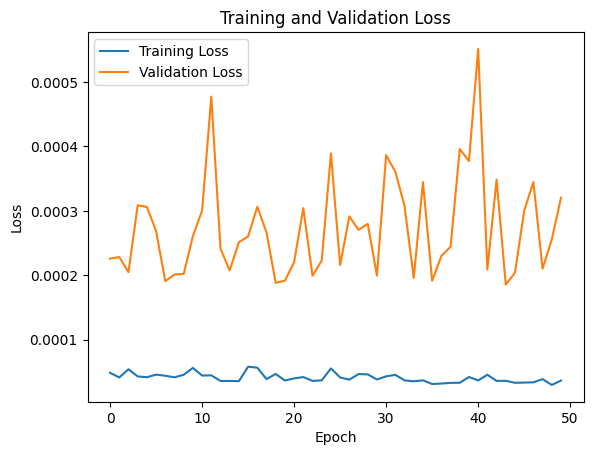

In [272]:
import matplotlib.pyplot as plt



plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### model prediction

In [22]:
# model result
# predict
# Adjust the shape of the predicted price to match the scaler’s expected input
predicted_prices = model.predict(X_test)
print(predicted_prices.shape)
#predicted_prices = predicted_prices.reshape(-1, 1)
predicted_prices = scaler_close.inverse_transform(predicted_prices)  # 现在

17/17 [==============================] - 2s 74ms/step
(523, 1)


In [23]:
# result
from sklearn.metrics import mean_squared_error
import math

# RMSE
real_prices = scaler_close.inverse_transform(y_test.reshape(-1, 1))

mae = mean_squared_error(real_prices, predicted_prices)
print("Mean Absolute Error (MAE):", mae)

rmse = math.sqrt(mean_squared_error(real_prices, predicted_prices))
print(f'RMSE: {rmse}')


Mean Absolute Error (MAE): 3619.25475452165
RMSE: 60.16024230770393


### 3. Automation

Epoch 1/10
66/66 [==============================] - 4s 18ms/step - loss: 0.0212
Epoch 2/10
66/66 [==============================] - 1s 17ms/step - loss: 0.0010
Epoch 3/10
66/66 [==============================] - 1s 19ms/step - loss: 5.1923e-04
Epoch 4/10
66/66 [==============================] - 1s 18ms/step - loss: 3.3612e-04
Epoch 5/10
66/66 [==============================] - 1s 17ms/step - loss: 2.4864e-04
Epoch 6/10
66/66 [==============================] - 1s 18ms/step - loss: 1.9546e-04
Epoch 7/10
66/66 [==============================] - 1s 18ms/step - loss: 1.6527e-04
Epoch 8/10
66/66 [==============================] - 2s 34ms/step - loss: 1.4034e-04
Epoch 9/10
66/66 [==============================] - 2s 37ms/step - loss: 1.2481e-04
Epoch 10/10
33/33 [==============================] - 1s 7ms/step
Neuron Count: 30, RMSE: 325.63033950406924
Epoch 1/10
66/66 [==============================] - 6s 41ms/step - loss: 0.0076
Epoch 2/10
66/66 [==============================] - 2s 38ms/step

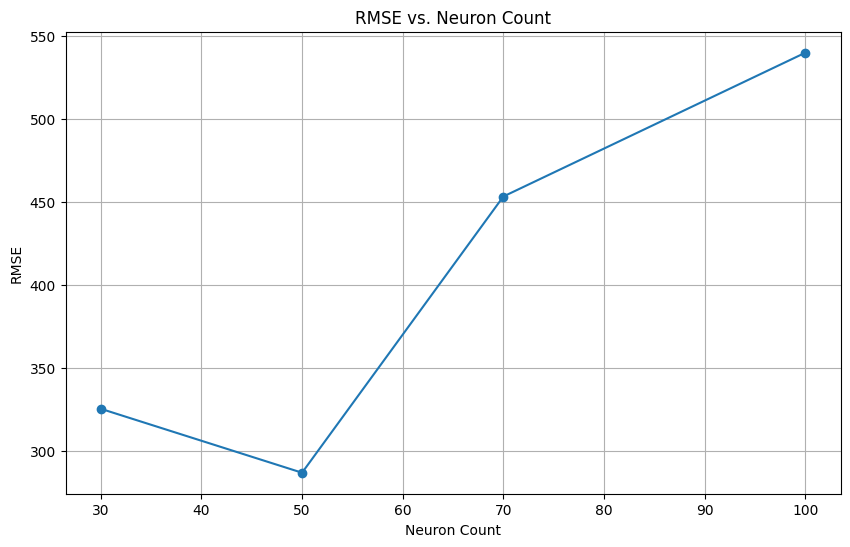

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

def train_and_evaluate_model(neuron_count):
    model = Sequential()
    #model.add(LSTM(neuron_count, return_sequences=True, input_shape=(time_period, 48)))
    model.add(LSTM(neuron_count, return_sequences=False, input_shape=(time_period, 48)))
    #model.add(Dense(250))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1)

    predicted_prices = model.predict(X_test)
    predicted_prices = scaler_close.inverse_transform(predicted_prices)

    real_prices = scaler_close.inverse_transform(y_test.reshape(-1, 1))
    rmse = math.sqrt(mean_squared_error(real_prices, predicted_prices))

    return rmse

neuron_counts = [30, 50, 70, 100]  # Example neuron counts to test
rmse_results = []

for count in neuron_counts:
    rmse = train_and_evaluate_model(count)
    rmse_results.append(rmse)
    print(f"Neuron Count: {count}, RMSE: {rmse}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(neuron_counts, rmse_results, marker='o')
plt.title('RMSE vs. Neuron Count')
plt.xlabel('Neuron Count')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()


In [ ]:
pd.DataFrame(rmse_results).to_csv("/simple_lstm_n_neurons_test.csv")

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

def train_and_evaluate_model(neuron_count):
    model = Sequential()
    #model.add(LSTM(neuron_count, return_sequences=True, input_shape=(time_period, 48)))
    model.add(LSTM(neuron_count, return_sequences=False, input_shape=(time_period, 48)))
    #model.add(Dense(250))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1)

    predicted_prices = model.predict(X_test)
    predicted_prices = scaler_close.inverse_transform(predicted_prices)

    real_prices = scaler_close.inverse_transform(y_test.reshape(-1, 1))
    rmse = math.sqrt(mean_squared_error(real_prices, predicted_prices))

    return rmse

neuron_counts = [10, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230, 250, 270, 290, 310, 330, 350, 370, 390, 410, 430,]  # Example neuron counts to test
rmse_results_i = []

for count in neuron_counts:
    rmse = train_and_evaluate_model(count)
    rmse_results_i.append(rmse)
    print(f"Neuron Count: {count}, RMSE: {rmse}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(neuron_counts, rmse_results_i, marker='o')
plt.title('RMSE vs. Neuron Count')
plt.xlabel('Neuron Count')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()
pd.DataFrame(rmse_results).to_csv("/simple_lstm_n_neurons_test_430.csv")

In [ ]:
rmse_results_i

In [60]:
### model 1.1
# model result
from sklearn.metrics import mean_squared_error
import math

# calculate（RMSE）
real_prices = scaler_close.inverse_transform(y_test.reshape(-1, 1))
rmse = math.sqrt(mean_squared_error(real_prices, predicted_prices))
print(f'RMSE: {rmse}')


RMSE: 74.4504198003147


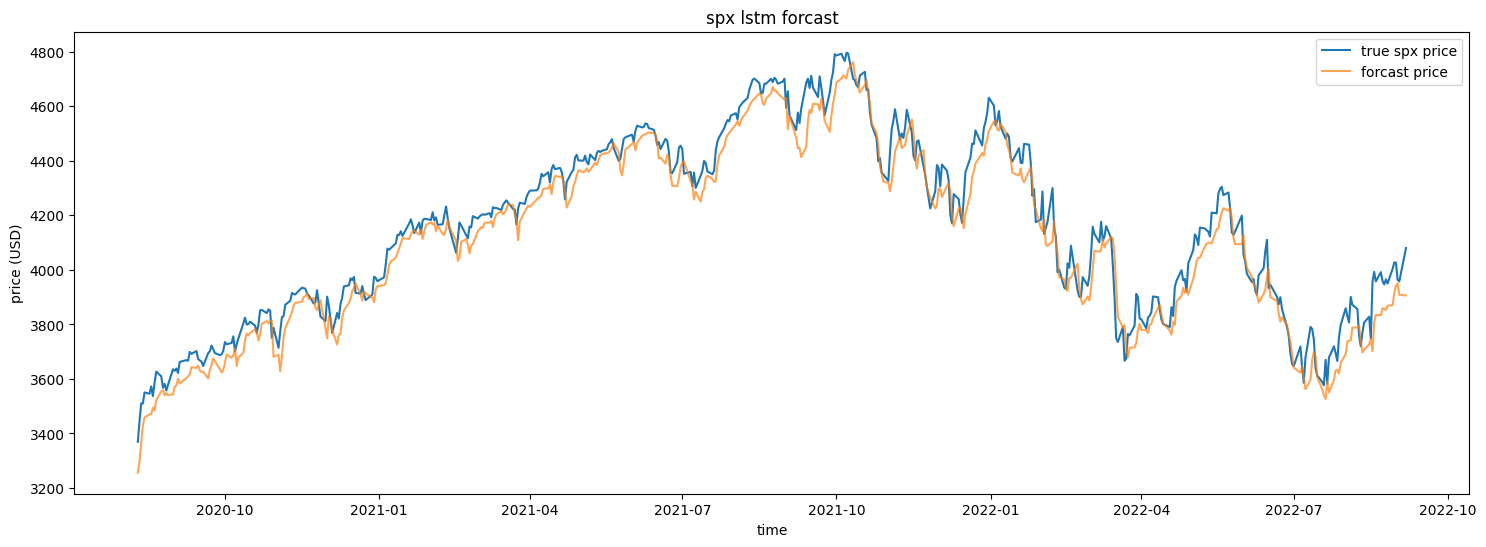

In [61]:
# plot
import matplotlib.pyplot as plt

time_axis = merged_data[Date_lis[train_size]:-time_period-1].index

# plot the real prices vs predict prices
plt.figure(figsize=(18, 6))
plt.plot(time_axis, real_prices, label='true spx price')
plt.plot(time_axis, predicted_prices, label='forcast price', alpha=0.7)
plt.title('spx lstm forcast')
plt.xlabel('time')
plt.ylabel('price (USD)')
plt.legend()
plt.show()


<Axes: >

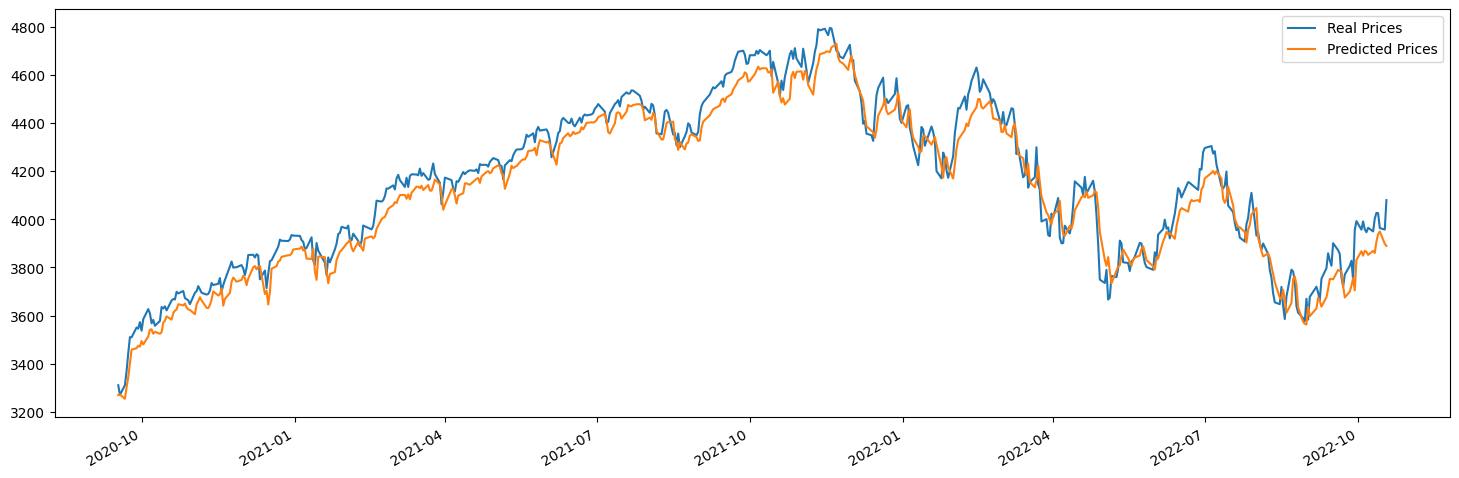

In [277]:
pd.DataFrame({'Real Prices': [i[0] for i in real_prices], 'Predicted Prices': [i[0] for i in predicted_prices]}, index=time_axis).plot(figsize=(18, 6))

In [62]:
Real_Predict_df = pd.DataFrame({'Real Prices': [i[0] for i in real_prices], 'Predicted Prices': [i[0] for i in predicted_prices]}, index=time_axis)

Real_Predict_df

,Real Prices,Predicted Prices
2020-08-10,3369.159912,3255.957275
2020-08-11,3443.439941,3296.763184
2020-08-12,3510.449951,3362.146484
2020-08-13,3509.439941,3428.669189
2020-08-14,3550.500000,3458.275879
...,...,...
2022-08-30,4027.260010,3914.386963
2022-08-31,4026.120117,3941.728516
2022-09-01,3963.939941,3950.183350
2022-09-02,3957.629883,3908.742188


## Backtesting

1.171340431667546
Total_profit
Total Profit: 0.1889
Total Trades: 435
Winning Trades: 223
Losing Trades: 212
Winning Percentage: 51.26%
Profit Factor: 1.1049
Annualized Return: 0.0002
Sharpe Ratio: -39.4596


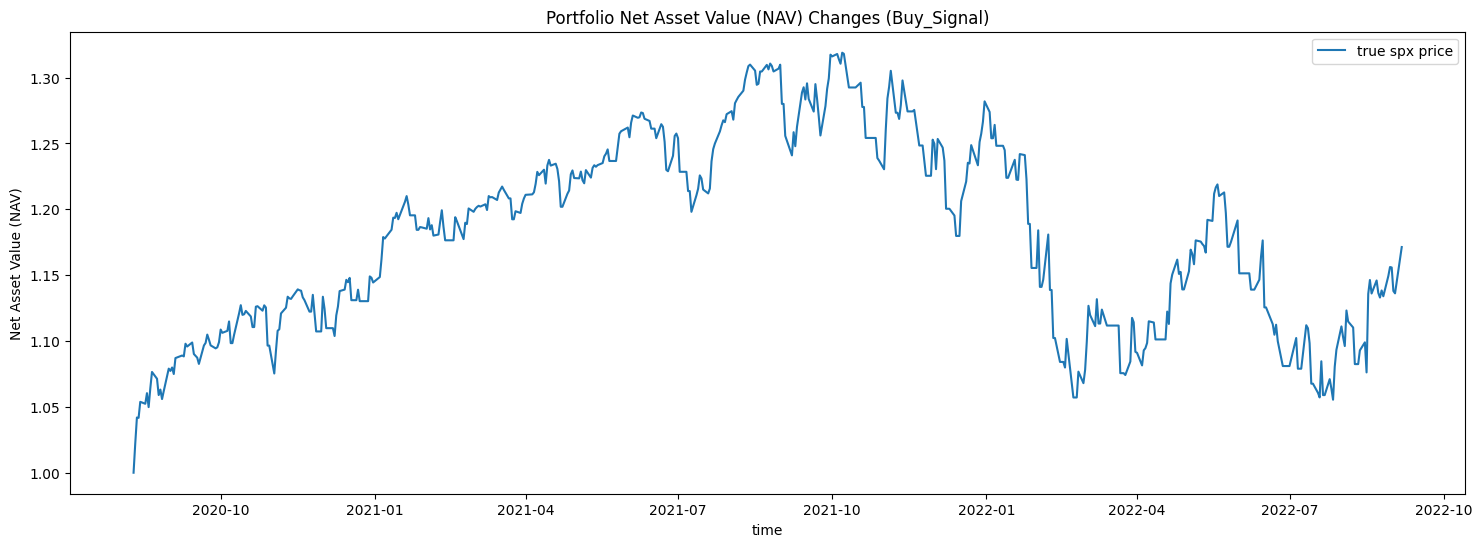

In [65]:
import pandas as pd
import numpy as np


# calculate the Buy_Signal and Sell_Signal
Real_Predict_df['Buy_Signal'] = Real_Predict_df['Predicted Prices'] > Real_Predict_df['Real Prices']
Real_Predict_df['Sell_Signal'] = Real_Predict_df['Predicted Prices'] <= Real_Predict_df['Real Prices']

# initialize the portfolio infomation
total_profit = 0
total_trades = 0
winning_trades = 0
losing_trades = 0
total_profit_percentage = 0
profits = []
initial_value = 1
portfolio_value_list = []
portfolio_value_list.append(initial_value)

# Finally, the trained model. Use it for trading backtesting. when the next day

# Loop through daily data
for i in range(len(Real_Predict_df) - 1):
    if Real_Predict_df['Sell_Signal'].iloc[i]:
        # buy if there is a trading signal and calculate holding a day's profit
        next_day_real_price = Real_Predict_df['Real Prices'].iloc[i + 1]
        buy_price = Real_Predict_df['Real Prices'].iloc[i]
        profit = (next_day_real_price - buy_price) / buy_price

        # sum
        total_profit += profit
        # value
        initial_value *=(1+profit)


        profits.append(profit)
        #print(profit)
        total_trades += 1
        if profit > 0:
            winning_trades += 1
        else:
            losing_trades += 1


        portfolio_value_list.append(initial_value)
    else:
        portfolio_value_list.append(initial_value)

print(initial_value)
# calculate annualizedreturn
annualized_return = ((total_profit / total_trades) + 1) ** (252 / len(Real_Predict_df)) - 1  # suppose 252 trading day a year
portfolio_value_list
# sharpe_ratio
daily_returns = pd.Series(profits)
risk_free_rate = 0.03  # risk free rate is 3%
sharpe_ratio = (daily_returns.mean() - risk_free_rate) / daily_returns.std() * np.sqrt(252)

# winning_percentage
winning_percentage = (winning_trades / total_trades) * 100

# profit_factor
profit_factor = -daily_returns[daily_returns > 0].sum() / daily_returns[daily_returns < 0].sum()

# print the result
print(f"Total_profit")
print(f"Total Profit: {total_profit:.4f}")
print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {winning_trades}")
print(f"Losing Trades: {losing_trades}")
print(f"Winning Percentage: {winning_percentage:.2f}%")
print(f"Profit Factor: {profit_factor:.4f}")
print(f"Annualized Return: {annualized_return:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

plt.figure(figsize=(18, 6))
plt.plot(time_axis, portfolio_value_list, label='true spx price')
plt.title('Portfolio Net Asset Value (NAV) Changes (Buy_Signal)')
plt.xlabel('time')
plt.ylabel('Net Asset Value (NAV)')
plt.legend()
plt.show()


1.0338728350300066
Total_profit
Total Profit: 0.0403
Total Trades: 87
Winning Trades: 43
Losing Trades: 44
Winning Percentage: 49.43%
Profit Factor: 1.0991
Annualized Return: 0.0002
Sharpe Ratio: -36.8191


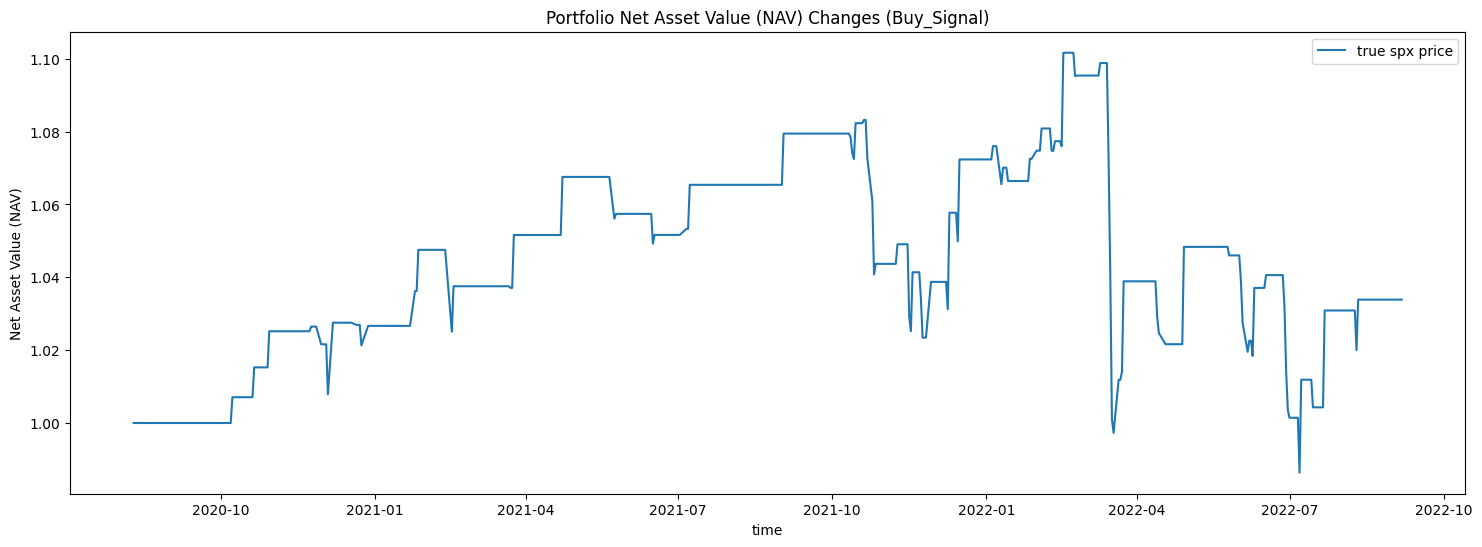

In [68]:
import pandas as pd
import numpy as np


# calculate the Buy_Signal and Sell_Signal
Real_Predict_df['Buy_Signal'] = Real_Predict_df['Predicted Prices'] > Real_Predict_df['Real Prices']
Real_Predict_df['Sell_Signal'] = Real_Predict_df['Predicted Prices'] <= Real_Predict_df['Real Prices']

# initialize the portfolio infomation
total_profit = 0
total_trades = 0
winning_trades = 0
losing_trades = 0
total_profit_percentage = 0
profits = []
initial_value = 1
portfolio_value_list = []
portfolio_value_list.append(initial_value)

# Finally, the trained model. Use it for trading backtesting. when the next day

# Loop through daily data
for i in range(len(Real_Predict_df) - 1):
    if Real_Predict_df['Buy_Signal'].iloc[i]:
        # buy if there is a trading signal and calculate holding a day's profit
        next_day_real_price = Real_Predict_df['Real Prices'].iloc[i + 1]
        buy_price = Real_Predict_df['Real Prices'].iloc[i]
        profit = (next_day_real_price - buy_price) / buy_price

        # sum
        total_profit += profit
        # value
        initial_value *=(1+profit)


        profits.append(profit)
        #print(profit)
        total_trades += 1
        if profit > 0:
            winning_trades += 1
        else:
            losing_trades += 1


        portfolio_value_list.append(initial_value)
    else:
        portfolio_value_list.append(initial_value)

print(initial_value)
# calculate annualizedreturn
annualized_return = ((total_profit / total_trades) + 1) ** (252 / len(Real_Predict_df)) - 1  # suppose 252 trading day a year
portfolio_value_list
# sharpe_ratio
daily_returns = pd.Series(profits)
risk_free_rate = 0.03  # risk free rate is 3%
sharpe_ratio = (daily_returns.mean() - risk_free_rate) / daily_returns.std() * np.sqrt(252)

# winning_percentage
winning_percentage = (winning_trades / total_trades) * 100

# profit_factor
profit_factor = -daily_returns[daily_returns > 0].sum() / daily_returns[daily_returns < 0].sum()

# print the result
print(f"Total_profit")
print(f"Total Profit: {total_profit:.4f}")
print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {winning_trades}")
print(f"Losing Trades: {losing_trades}")
print(f"Winning Percentage: {winning_percentage:.2f}%")
print(f"Profit Factor: {profit_factor:.4f}")
print(f"Annualized Return: {annualized_return:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

plt.figure(figsize=(18, 6))
plt.plot(time_axis, portfolio_value_list, label='true spx price')
plt.title('Portfolio Net Asset Value (NAV) Changes (Buy_Signal)')
plt.xlabel('time')
plt.ylabel('Net Asset Value (NAV)')
plt.legend()
plt.show()

## Save the model

In [67]:
# save the model
model.save('model_LSTM200_25dense_v5.7.h5')

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Set the start and end dates
start_date = "2001-01-01"
end_date = "2023-01-01"

# Download S&P 500 historical data from Yahoo Finance
sp500_data = yf.download('^GSPC', start=start_date, end=end_date)

# Extract the 'Close' price as the target variable
sp500_data = sp500_data[['Close']]

# Normalize the data
scaler = MinMaxScaler()
sp500_data['Close'] = scaler.fit_transform(sp500_data['Close'].values.reshape(-1, 1))

# Split the data into training and testing sets (80% training, 20% testing)
split_percentage = 0.9
split_index = int(len(sp500_data) * split_percentage)
train_data = sp500_data.iloc[:split_index]
test_data = sp500_data.iloc[split_index:]

# Define a function to prepare the data for the LSTM model
def prepare_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Define the window size (e.g., 30 days)
window_size = 60

# Prepare the training and testing data for the LSTM model
X_train, y_train = prepare_data(train_data.values, window_size)
X_test, y_test = prepare_data(test_data.values, window_size)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {test_loss}')

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predictions to get actual prices
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

# Plot the actual vs. predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(predictions, label='Predicted Prices', color='red')
plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()